# 1.Импорт модулей

In [ ]:
! python --version

Python 3.8.16


In [ ]:
!pip install tensorflow_hub==0.10.0
!pip install keras==2.4.3
!pip install tf-models-official==2.3.0
!pip install pydot==1.3.0
!pip install graphviz==0.10.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 107 kB 5.0 MB/s 
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.12.0
    Uninstalling tensorflow-hub-0.12.0:
      Successfully uninstalled tensorflow-hub-0.12.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: keras
    Found existing installation: keras 2.9.0
    Uninstalling keras-2.9.0:
      Successfully uninstalled keras-2.9.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.9.2 requires keras<2.10.0,>=2.9.0rc0, but you have keras 2.4.3 which is incompatible.
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |███████████████████████████████

In [ ]:
import os

import numpy as np
import pandas as pd

import tensorflow as tf
import tensorflow_hub as hub

from keras.utils import np_utils

import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization as tokenization

from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices('GPU') else "NOT AVAILABLE")

1 Physical GPUs, 1 Logical GPUs
Version:  2.9.2
Eager mode:  True
Hub version:  0.10.0
GPU is available


# 2.Данные

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/train_clean.csv')
train_df.head()

,bank,feeds,grades,date,sym_len,word_len,lemmas
0,unicreditbank,Я очень редко пользуюсь банковскими продуктами...,5.0,2017-12-31 18:20:00,770,119,очень редко пользоваться банковский продукт не...
1,fk_otkritie,Я вместе с женой 15.11.2019 обратился в отделе...,1.0,2019-11-22 22:42:00,2749,405,вместе жена обратиться отделение банк открытие...
2,alfabank,Добрый день.Сегодня 27.12.2018 г около 15.40-1...,1.0,2018-12-27 23:20:00,867,128,добрый день сегодня г около банкомат адрес ряз...
3,vtb,"""Где карточку открывали, туда и идите..."" - эт...",2.0,2020-02-05 16:40:00,2860,462,карточка открывать туда идти этот фраза давно ...
4,promsvyazbank,При покупках в iTunes списываются завышенные с...,NaN,2016-02-26 15:48:00,1066,161,покупка itunes списываться завысить сумма прим...


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp/test_clean.csv')
test_df.head()

,bank,feeds,date,lemmas
0,sberbank,История такова: 27.01.2015 мне на телефон приш...,05.02.2015 17:33,история таков телефон прийти подряд смс списан...
1,alfabank,"Нельзя решить ни один вопрос оперативно, автоо...",03.03.2021 9:27,решить вопрос оперативно автоответчик отказыва...
2,tcs,"Быстро, удобно, чего ещё нужно то. На сайтике ...",09.04.2018 7:40,быстро удобно нужно сайтик быстро оформить док...
3,pochtabank,Добрый день! Просто в шоке от ПАО «Почта Банк...,09.04.2020 9:57,добрый день просто шок пао почта банк обратить...
4,sberbank,В течение выходных дней новогоднего периода 20...,12.01.2012 14:00,течение выходной день новогодний период банком...


In [ ]:
train_df.grades.unique()

array([ 5.,  1.,  2., nan,  3.,  4.])

Посмотрим распределение классов в трейне

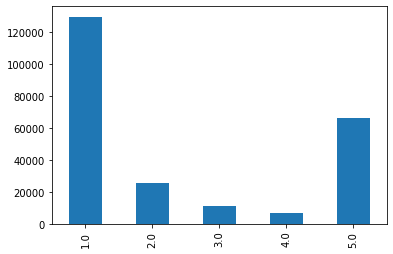

In [ ]:
classes = train_df.grades.value_counts().sort_index().plot(kind='bar')
plt.show()

## 2.1.Train/test split

In [ ]:
train_df = train_df.dropna()
train_df['grades'] = train_df['grades'].astype('int8') - 1

In [ ]:
train_df_short = train_df[train_df['word_len'] <= 1000]
train_df_short.shape

(239447, 7)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_df_short.feeds, train_df_short.grades,
                                                    train_size=100000, test_size=5000, 
                                                    stratify=train_df_short.grades, random_state=42)
# df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test.grades, random_state=RANDOM_SEED)

In [ ]:
x_train.shape

(100000,)

In [ ]:
y_train.value_counts(normalize=True)

0    0.53989
4    0.27711
1    0.10723
2    0.04626
3    0.02951
Name: grades, dtype: float64

In [ ]:
np.random.seed(42)
idx_drop = np.random.choice(y_train[(y_train == 0)].index, size=int(y_train[(y_train == 0)].shape[0] * 0.5), replace=False)
idx_drop1 = np.random.choice(y_train[(y_train == 4)].index, size=int(y_train[(y_train == 4)].shape[0] * 0.3), replace=False)
y_train = y_train.drop(index=np.hstack((idx_drop, idx_drop1)))
x_train = x_train.drop(index=np.hstack((idx_drop, idx_drop1)))

In [ ]:
y_train.value_counts(normalize=True)

0    0.417279
4    0.299847
1    0.165752
2    0.071507
3    0.045615
Name: grades, dtype: float64

## 2.2.Label Encoding

(Использование LE не совсем обязательно в данном кейсе, т.к. у нас уже классы в данных представлены нужным образом (числа от 0 до число классов - 1), но в более общем случае это необходимо)

In [ ]:
encoder = LabelEncoder()
encoder.fit(train_df.grades)
encoded_Y_test = encoder.transform(y_test)
encoded_Y_train = encoder.transform(y_train)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test = np_utils.to_categorical(encoded_Y_test)
dummy_y_train = np_utils.to_categorical(encoded_Y_train)

Сохраним наш зафиченный LE

In [ ]:
encoder_fname = 'review_classes.npy'
my_wd = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp_tf_attempt/'
np.save(os.path.join(my_wd, encoder_fname) , encoder.classes_)

Так можно его скачать

In [ ]:
# encoder = LabelEncoder()
# encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

## 2.3.Токенизация

Для токенизации используются функции из official.nlp.bert и pretrained BERT. \\
Скачаем саму модельку.

In [ ]:
bert_layer = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/2", # https://tfhub.dev/jeongukjae/distilbert_multi_cased_L-6_H-768_A-12/1
                            trainable=True)

In [ ]:
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
do_lower_case

False

In [ ]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [ ]:
def encode_names(n):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')  # seperation token. Would bemuch more useful if you had a multiple text input.
   return tokenizer.convert_tokens_to_ids(tokens)

tokenized_reviews = tf.ragged.constant(x_train.apply(encode_names))
#[encode_names(n) for n in x_train])

In [ ]:
print('Tokenized reviews shape', tokenized_reviews.shape.as_list())

Tokenized Tweets shape [64692, None]


In [ ]:
tokenized_reviews[0]

<tf.Tensor: shape=(385,), dtype=int32, numpy=
array([   101,  12834,  12409,    117,  10949,    557,  12686,  33262,
        13097,    117,  10297,    553,  17117,  10384,  12709,  11833,
        18106,    117,  96569,  10674,  10234,  51642,  11191,  10122,
        91258,  21137,    549,  53204,  10696,  18088,    551,  63796,
        10367,    543,    511,  20411,  18683,  65727,    117,  83415,
          113,  10430,  33276,  43402,    114,  11582,  91258,  27552,
          543,  21148,    123,    118,    562,  10375,  70835,    119,
        35475,  60515,  11548,  16673,  10521,  13414,  96195,  10990,
        85987,    117,  10297,  72013,    558,  23807,  54256,  10508,
        15597,  65727,  10433,    119,    523,  92274,  45709,    558,
        79050,  10191,    555,  88361,  97099,    117,  10332,  54697,
        13248,    555,  88361,  11557,  18731,  11240,    543,  65727,
          543,  21148,    124,    118,    562,  58385,  29835,    113,
        10949,    549,  11582, 

Посмотрим процесс токенизации на каком-нибудь примере.

In [ ]:
x_train.iloc[0]

'После того, как риелтор, по моей просьбе, направила заявку на получение ипотечного кредита в ВТБ банк, ответ (одобрение) было получено в течение 2-х недель. Процентная ставка является выгодной, по сравнению с предложениями других банков. Оперативно сработали оценщики, отчет об оценке передан в банк в течение 3-х рабочих дней (как и было оговорено специалистом). На 4-й день я уже получила на ознакомление договор Купли-продажи. В этот же день была обозначена дата, в которую должна состояться сделка. Вся процедура оформления документов заняла не более часа. Потом в МФЦ на оформление документов, тоже не более часа, потом снова в банк, сдать документы с МФЦ. Это все в один день. Через 5 дней снова в МФЦ, уже за выпиской из ЕГРП, оттуда в банк и вот долгожданный момент: документы уже на руках, ключи от квартиры мне передали в банке!Хотелось бы дополнить отзыв тем, что очень удобно пользоваться личным кабинетом. Отображен как сам долг, так и все условия, на которых он появился.Что касается р

In [ ]:
tokenizedreview = tokenizer.tokenize(x_train.iloc[0])
for i in tokenizedreview:
  print(i, tokenizer.convert_tokens_to_ids([i]))

После [12834]
того [12409]
, [117]
как [10949]
р [557]
##ие [12686]
##лт [33262]
##ор [13097]
, [117]
по [10297]
м [553]
##ое [17117]
##й [10384]
про [12709]
##сь [11833]
##бе [18106]
, [117]
направи [96569]
##ла [10674]
за [10234]
##яв [51642]
##ку [11191]
на [10122]
полу [91258]
##чение [21137]
и [549]
##по [53204]
##те [10696]
##чного [18088]
к [551]
##реди [63796]
##та [10367]
в [543]
В [511]
##Т [20411]
##Б [18683]
банк [65727]
, [117]
ответ [83415]
( [113]
од [10430]
##об [33276]
##рение [43402]
) [114]
было [11582]
полу [91258]
##чено [27552]
в [543]
течение [21148]
2 [123]
- [118]
х [562]
не [10375]
##дель [70835]
. [119]
Про [35475]
##цент [60515]
##ная [11548]
став [16673]
##ка [10521]
является [13414]
вы [96195]
##го [10990]
##дной [85987]
, [117]
по [10297]
сравнению [72013]
с [558]
пред [23807]
##ложения [54256]
##ми [10508]
других [15597]
банк [65727]
##ов [10433]
. [119]
О [523]
##пера [92274]
##тивно [45709]
с [558]
##работал [79050]
##и [10191]
о [555]
##цен [88361]
##

Необходимо добавить CLS токен.

In [ ]:
cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * tokenized_reviews.shape[0]
input_word_ids = tf.concat([cls, tokenized_reviews], axis=-1)

## 2.4.Mask and input type

Модель ожидает как инпут:
* Токен
* input mask
* input type  
Здесь и выше просто код с попытками посмтроить пайплайн предобработки, который потом соберется в единую функцию предобработки

In [ ]:
# input_word_ids

In [ ]:
input_mask = tf.ones_like(tokenized_reviews).to_tensor()

In [ ]:
type_cls = tf.zeros_like(cls)
type_tweet = tf.ones_like(tokenized_reviews)
input_type_ids = tf.concat([type_cls, type_tweet], axis=-1).to_tensor()

It's hard to see but we added an empty block in front of each tweet for the `[CLS]` token. Check tensor below

In [ ]:
input_type_ids

<tf.Tensor: shape=(64692, 7123), dtype=int32, numpy=
array([[0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       ...,
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0],
       [0, 1, 1, ..., 0, 0, 0]], dtype=int32)>

## 2.5.Переделаем всю эту процедуру в одну функцию

So at this point we have all of our three inputs:

1.   Tokens
2.   Input mask
3.   Input type

It will make our work easier both now and in the future if we remake everything into funcitons.



First let's set the max sequence lenght as we did in simple NN example.

In [ ]:
lens = [len(i) for i in tokenized_reviews]

In [ ]:
max_seq_length = max(lens)
print('Max length is:', max_seq_length)

Max length is: 7122


Most of the time I suggest adding a bit more to the `max_seq_length` esspecially when ussing just a fraction of data. Let's make it `1.5*max_seq_length`.

In [ ]:
# max_seq_length = int(1.5*max_seq_length)
# print('Max length is:', max_seq_length)

Max length is: 240


In [ ]:
max_seq_length = 512

In [ ]:
def encode_names(n, tokenizer):
   tokens = list(tokenizer.tokenize(n))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(string_list, tokenizer, max_seq_length):
  num_examples = len(string_list)
  
  string_tokens = tf.ragged.constant([
      encode_names(n, tokenizer) for n in np.array(string_list)])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])] * string_tokens.shape[0]
  input_word_ids = tf.concat([cls, string_tokens], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor(shape=(None, max_seq_length))

  type_cls = tf.zeros_like(cls)
  type_tokens = tf.ones_like(string_tokens)
  input_type_ids = tf.concat(
      [type_cls, type_tokens], axis=-1).to_tensor(shape=(None, max_seq_length))

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(shape=(None, max_seq_length)),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

Выполним предобработку выделенных ранее обучающей и валидационной выборки

In [ ]:
X_train = bert_encode(x_train, tokenizer, max_seq_length)
X_test = bert_encode(x_test, tokenizer, max_seq_length)

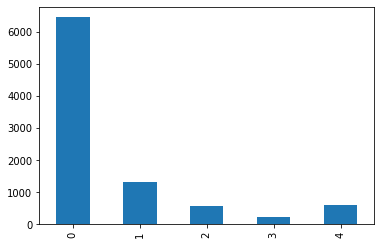

In [ ]:
train_df[train_df.word_len > 512].grades.value_counts().sort_index().plot(kind='bar')
plt.show()

# 3.Обучение BERT

## 3.1.Initial training

Задаем архитектуру модели

In [ ]:
num_class = len(encoder.classes_)  # Based on available class selection
max_seq_length = max_seq_length  # we calculated this a couple cells ago

input_word_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                   name="input_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_length,), dtype=tf.int32,
                                    name="segment_ids")

pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])                                  

output = tf.keras.layers.Dropout(rate=0.2)(pooled_output)

output = tf.keras.layers.Dense(num_class, activation='softmax', name='output')(output)

model = tf.keras.Model(
    inputs={
        'input_word_ids': input_word_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
        },
        outputs=output)

Визуализируем модель.

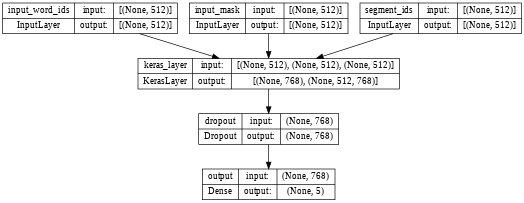

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True, dpi=48)

Зададим параметры числа эпох, bs и т.д.

In [ ]:
epochs = 3
batch_size = 8  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Compile the model.

In [ ]:
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

Запускаем процесс обучения

In [ ]:
history = model.fit(X_train,
                    dummy_y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    validation_data=(X_test, dummy_y_test),
                    verbose=1)

Epoch 1/3
8087/8087 [==============================] - 8724s 1s/step - loss: 0.8972 - accuracy: 0.6674 - val_loss: 0.6426 - val_accuracy: 0.7932
Epoch 2/3
 521/8087 [>.............................] - ETA: 2:10:52 - loss: 0.7914 - accuracy: 0.6903

KeyboardInterrupt: ignored

Evaluation (очень долгий для берта, лучше не запускать)

In [ ]:
loss, accuracy = model.evaluate(X_train, dummy_y_train, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Визуализация качества по эпохам (у меня была всего одна, поэтому визуализировать две точки имеет не очень много смысла)

In [ ]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

In [ ]:
plot_history(history)

## 3.2.Сохранение обученной модели

Сохраним модель для переиспользования.

In [ ]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'reviews_BERT'
my_wd = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp_tf_attempt/'

model.save(os.path.join(my_wd, model_fname))

### Валидация сохраненной модели

Проверим, что все сохранилось корректно

In [ ]:
model_fname = 'reviews_BERT'
my_wd = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp_tf_attempt/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.7862


In [ ]:
new_model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 240)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 240)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 240)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 768), (None, 177853441   input_word_ids[0][0]             
                                                                 input_mask[0][0]      

Лучше так же перепроверить tokenizer.

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

Вроде, все в порядке

In [ ]:
tokenizedREV = tokenizerSaved.tokenize(x_train[0])
for i in tokenizedREV:
  print(i, tokenizerSaved.convert_tokens_to_ids([i]))

## 3.3. Вторая итерация обучения

### Данные

Возьмем трейн и валидационную выборки с другим сидом, чтобы постараться повысить качество

In [ ]:
x_train2, x_test2, y_train2, y_test2 = train_test_split(train_df_short.feeds, train_df_short.grades,
                                                        train_size=60000, test_size=5000, 
                                                        stratify=train_df_short.grades, random_state=15)
# df_val, df_test = train_test_split(df_test, test_size=0.5, stratify=df_test.grades, random_state=RANDOM_SEED)

In [ ]:
x_train2.shape

(60000,)

In [ ]:
y_train2.value_counts(normalize=True)

0    0.539900
4    0.277117
1    0.107233
2    0.046250
3    0.029500
Name: grades, dtype: float64

In [ ]:
np.random.seed(42)
idx_drop = np.random.choice(y_train2[(y_train2 == 0)].index, size=int(y_train2[(y_train2 == 0)].shape[0] * 0.5), replace=False)
idx_drop1 = np.random.choice(y_train2[(y_train2 == 4)].index, size=int(y_train2[(y_train2 == 4)].shape[0] * 0.3), replace=False)
y_train2 = y_train2.drop(index=np.hstack((idx_drop, idx_drop1)))
x_train2 = x_train2.drop(index=np.hstack((idx_drop, idx_drop1)))

In [ ]:
y_train2.value_counts(normalize=True)

0    0.417287
4    0.299858
1    0.165761
2    0.071493
3    0.045601
Name: grades, dtype: float64

In [ ]:
x_train2.shape

(38815,)

#### Label Encoding

In [ ]:
encoder_fname = 'review_classes.npy'
my_wd = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp_tf_attempt/'

encoder = LabelEncoder()
encoder.classes_ = np.load(os.path.join(my_wd, encoder_fname), allow_pickle=True)

encoded_Y_test2 = encoder.transform(y_test2)
encoded_Y_train2 = encoder.transform(y_train2)

# convert integers to dummy variables (i.e. one hot encoded)
dummy_y_test2 = np_utils.to_categorical(encoded_Y_test2)
dummy_y_train2 = np_utils.to_categorical(encoded_Y_train2)

#### Input preprocessing
Выполним ту же предобработку, что и раньше

In [ ]:
model_fname = 'reviews_BERT'
my_wd = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp_tf_attempt/'

tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
X_train2 = bert_encode(x_train2, tokenizerSaved, max_seq_length)
X_test2 = bert_encode(x_test2, tokenizerSaved, max_seq_length)

### Training

In [ ]:
model_fname = 'reviews_BERT'
my_wd = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp_tf_attempt/'

new_model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_word_ids (InputLayer)    [(None, 512)]        0           []                               
                                                                                                  
 input_mask (InputLayer)        [(None, 512)]        0           []                               
                                                                                                  
 segment_ids (InputLayer)       [(None, 512)]        0           []                               
                                                                                                  
 keras_layer (KerasLayer)       [(None, 768),        177853441   ['input_word_ids[0][0]',         
                                 (None, 512, 768)]                'input_mask[0][0]',         

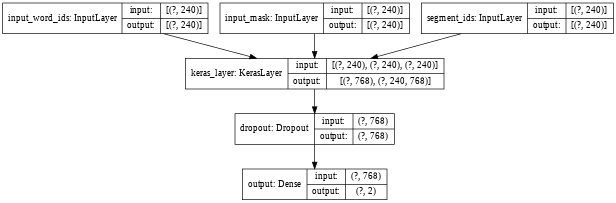

In [ ]:
tf.keras.utils.plot_model(new_model, show_shapes=True, dpi=48)

In [ ]:
loss, accuracy = new_model.evaluate(X_test, dummy_y_test, verbose=False)  # OLD
print("Old testing Accuracy:  {:.4f}".format(accuracy))

loss, accuracy = new_model.evaluate(X_test2, dummy_y_test2, verbose=False)  # NEW
print("New testing Accuracy:  {:.4f}".format(accuracy))

Old testing Accuracy:  0.8291
New testing Accuracy:  0.8367


In [ ]:
epochs = 3
batch_size = 4  # select based on your GPU resources
eval_batch_size = batch_size

train_data_size = len(dummy_y_train2)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

In [ ]:
optimizer = nlp.optimization.create_optimizer(
    1e-7, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

Let's compile our model.

In [ ]:
new_model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

And now finally we can train again and see if that helps us achieve a better accuracy.

In [ ]:
history2 = new_model.fit(X_train2,  # using new training set
                         dummy_y_train2,  # using new training set
                         epochs=epochs,
                         batch_size=batch_size,
                         validation_data=(X_test, dummy_y_test),  # using old test dataset
                         verbose=1)

Epoch 1/3
4670/9704 [=============>................] - ETA: 48:18 - loss: 0.7796 - accuracy: 0.7011

KeyboardInterrupt: ignored

Let's plot everything out.

In [ ]:
for i in history2.history:
  for ele in history2.history[i]:
    history.history[i].append(ele)

In [ ]:
plot_history(history)

# Test

Предобработаем тестовый датасет и сделаем предикт

In [ ]:
tokenizerSaved = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
test_bert_encoded = bert_encode(test_df.feeds, tokenizerSaved, max_seq_length) 

In [ ]:
prediction1 = new_model.predict(test_bert_encoded)

1067/1067 [==============================] - 1489s 1s/step


In [ ]:
test_df.shape

(34114, 4)

In [ ]:
preds = np.argmax(prediction1, axis=1) + 1 # best

In [ ]:
sol = pd.DataFrame({'inds': test_df.index,
                    'grades': preds})
sol
sol.to_csv('bert_tf_heavy_tuned.csv', index=False) # best

Сохранение дотюненной (после 2-й итерации) модели

In [ ]:
new_model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model_fname = 'reviews_BERT_tuned'
my_wd = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp_tf_attempt/'

new_model.save(os.path.join(my_wd, model_fname))

Снова проверка, что модель сохранилась нормально

In [ ]:
model_fname = 'reviews_BERT_tuned'
my_wd = '/content/drive/MyDrive/Colab Notebooks/NLP/bootcamp_tf_attempt/'

model = tf.keras.models.load_model(os.path.join(my_wd, model_fname))

In [ ]:
loss, accuracy = model.evaluate(X_test2, dummy_y_test2, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))

Testing Accuracy:  0.8014


In [ ]:
tokenizerSaved1 = bert.tokenization.FullTokenizer(
    vocab_file=os.path.join(my_wd, model_fname, 'assets/vocab.txt'),
    do_lower_case=False)

In [ ]:
tokenized_rev_check = tokenizerSaved1.tokenize(x_train[0])
for i in tokenized_rev_check:
  print(i, tokenizerSaved1.convert_tokens_to_ids([i]))

Я [540]
очень [20598]
редко [99004]
пользу [79463]
##ю [10593]
##сь [11833]
банк [65727]
##овски [91945]
##ми [10508]
продукт [65501]
##ами [12040]
. [119]
Но [19732]
необходимо [58330]
##сть [12737]
к [551]
##реди [63796]
##та [10367]
во [10439]
##зни [68070]
##кла [58224]
. [119]
Так [20275]
как [10949]
в [543]
Ю [539]
##ник [11718]
##реди [63796]
##т [10351]
Ба [101086]
##нке [48635]
об [13248]
##слу [87098]
##живают [80629]
##ся [10625]
почти [21797]
все [13686]
близ [76606]
##кие [27441]
род [17517]
##ствен [73036]
##ники [17785]
, [117]
проблем [35607]
с [558]
вы [96195]
##бор [20545]
##ом [10364]
о [555]
##фи [26245]
##са [12016]
не [10375]
было [11582]
. [119]
Я [540]
при [10913]
##шла [30520]
по [10297]
рек [70158]
##оме [102276]
##нда [12903]
##ции [12559]
к [551]
Константин [33827]
##у [10227]
То [31217]
##л [10517]
##ма [10993]
##чев [32702]
##у [10227]
. [119]
Мы [64820]
очень [20598]
быстро [48823]
за [10234]
##по [53204]
##лни [22523]
##ли [10783]
за [10234]
##яв [51642]